<!-- dom:TITLE: Guassian Process Regression by Example -->
# Guassian Process Regression by Example
<!-- dom:AUTHOR: Landman Bester -->
<!-- Author: --> **Landman Bester**

Date: **Oct 28, 2016**

**Summary.** A very quick and hands on intro to Gaussian process regression (GPR). There is a growing body of literature and interest in Gaussian processes. This tut is based on some of the material covered here (http://www.gaussianprocess.org/) and some of the lessons I have learned playing around with them myself. There are a number of existing python packages which can perform GPR for you (eg. Gpy, scikit-learn and george to name a few). However, GPs are very flexible tools which can be adapted to perform very specific tasks. It is unlikely that a single package will be able to fulfill all your needs. The aim of this tutorial is to provide some tools that will help you to develop some familiarity with Gaussian processes and, hopefully, learn to adapt them for yourself.

In [14]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact

# Introducing the Gaussian Process Regression (GPR) problem
In its most basic form a Gaussian process (GP) is a collection of random variables, any finite subset of which have a joint Gaussian distribution. A GP can be completely characterised by specifying its mean $m(\mathbf{x})$ and covariance $k(\mathbf{x},\tilde{\mathbf{x}})$ functions. The mean and covariance function of a real process $f(\mathbf{x})$ are defined by

$$
\begin{align*}
m(\mathbf{x}) &= \mathbb{E}_{\mathcal{N}}[f(\mathbf{x})], \\
k(\mathbf{x},\tilde{\mathbf{x}}) &= \mathbb{E}_{\mathcal{N}}[(f(\mathbf{x}) - m(\mathbf{x}))(f(\tilde{\mathbf{x}}) - m(\tilde{\mathbf{x}}))].
\end{align*}
$$

This is conveniently abbreviated using the notation $f(\mathbf{x}) \sim \mathcal{G}\mathcal{P}(m(\mathbf{x}),k(\mathbf{x},\tilde{\mathbf{x}}))$. Note that the notation $\mathbb{E}_{\mathcal{N}}[\cdot]$ is used to denote the expectation value with respect to a Gaussian distribution. Restricting to 1D input variables for now, we may replace $\mathbf{x}$ by $x$ in the above equations. 

Suppose that we want to perform GPR on a data set

<!-- Equation labels as ordinary links -->
<div id="Eq.1"></div>

$$
\begin{equation}
\mathcal{D}_y = \left[x_i, y_i, \delta y_i \right] \label{Eq.1} \tag{1}
\end{equation}
$$

where the $y_i$ are observations of a function, $f(x)$ say, at the locations $x_i$ and $\delta y_i$ are the uncertainties on these observations. In other words we have

<!-- Equation labels as ordinary links -->
<div id="Eq.2"></div>

$$
\begin{equation}
y_i = f(x_i) + \delta y_i, \label{Eq.2} \tag{2}
\end{equation}
$$

The GPR problem consists of inferring the underlying function $f(x)$ from the data. GPR is useful for numerous other applications eg. differentiating data, incorporating explicit basis function. However, before delving into the details, let's review some topics from our statistics bible.

# Probability and Bayes law
The joint probability of a finite dimensional vector $\mathbf{y} = [y_1,y_2,\cdots,y_D]$ of dimension $D$ is denoted $p(\mathbf{y})$. The set $\mathbf{y}$ can be partitioned into a number of disjoint subsets, each playing a different part in the model. This simple operation is at the heart of Bayesian modelling. To illustrate the general idea we partition $\mathbf{y}$ into two disjoint subsets $\mathbf{y}_A$ and $\mathbf{y}_B$ and write their joint probability distribution as $p(\mathbf{y}_A,\mathbf{y}_B)$. The marginal probability of $\mathbf{y}_A$ is defined as

<!-- Equation labels as ordinary links -->
<div id="Eq.3"></div>

$$
\begin{equation}
p(\mathbf{y}_A) := \int p(\mathbf{y}_A,\mathbf{y}_B) d \mathbf{y}_B. \label{Eq.3} \tag{3}
\end{equation}
$$

The marginal probability expresses the joint probability of $\mathbf{y}_A$ regardless of the possible values that $\mathbf{y}_B$ can take. If the parameters are independent the act of marginalisation has no effect. In that case the joint probability is simply the product of the marginals i.e. $p(\mathbf{y}_A,\mathbf{y}_B) = p(\mathbf{y}_A)p(\mathbf{y}_B)$. Another concept that plays an important role in Bayesian modelling is the conditional probability. The joint probability distribution of $\mathbf{y}_A$ conditioned on the values of $\mathbf{y}_B$ is defined as

<!-- Equation labels as ordinary links -->
<div id="Eq.4"></div>

$$
\begin{equation}
p(\mathbf{y}_A |\mathbf{y}_B) := \frac{p(\mathbf{y}_A,\mathbf{y}_B)}{p(\mathbf{y}_B)} \label{Eq.4} \tag{4}
\end{equation}
$$

Whereas ([Eq.3](#Eq.3)) allows us to describe the joint probability distribution of $\mathbf{y}_A$ independently of $\mathbf{y}_B$, ([Eq.4](#Eq.4)) describes the joint probability of $\mathbf{y}_A$ given the values (or distributions) of $\mathbf{y}_B = Y_B$. If $\mathbf{y}_A$ and $\mathbf{y}_B$ are independent then these two operations are equivalent and the conditional and marginal distributions will be identical. Note that we can combine the two definitions ([Eq.3](#Eq.3)) and ([Eq.4](#Eq.4)) to rewrite the marginalised probability as

<!-- Equation labels as ordinary links -->
<div id="Eq.5"></div>

$$
\begin{equation}
p(\mathbf{y}_A) = \int p(\mathbf{y}_A | \mathbf{y}_B) p(\mathbf{y}_B) d \mathbf{y}_B. \label{Eq.5} \tag{5}
\end{equation}
$$

Bayes' theorem, which can be established from the fact that $p(\mathbf{y}_A,\mathbf{y}_B) = p(\mathbf{y}_B,\mathbf{y}_A)$ and the definition of conditional probability, states that

<!-- Equation labels as ordinary links -->
<div id="Eq.6"></div>

$$
\begin{equation}
p(\mathbf{y}_A |\mathbf{y}_B) = \frac{p(\mathbf{y}_B | \mathbf{y}_A)p(\mathbf{y}_A)}{p(\mathbf{y}_B)} = \frac{\mbox{likelihood} \times \mbox{prior}}{\mbox{marginal likelihood}}. \label{Eq.6} \tag{6}
\end{equation}
$$

In the Bayesian interpretation we identify $p(\mathbf{y}_B | \mathbf{y}_A)$ as the likelihood, $p(\mathbf{y}_A)$ as the prior, $p(\mathbf{y}_B)$ as the evidence or marginal likelihood and $p(\mathbf{y}_A |\mathbf{y}_B)$ as the posterior probability. We will find it useful to review the properties of the multivariate Gaussian distribution.

# The multivariate Gaussian distribution
Recall that a jointly Gaussian random vector $\mathbf{y} = [y_1,y_2,\cdots,y_n]$ has probability density given by

<!-- Equation labels as ordinary links -->
<div id="Eq.7"></div>

$$
\begin{equation}
p(\mathbf{y|\bar{y}},\Sigma_y) = (2\pi)^{-n/2} |\Sigma_y|^{-1/2} \exp \left(-\frac{1}{2}(\mathbf{y} - \bar{\mathbf{y}})^T \Sigma^{-1}_y(\mathbf{y} - \bar{\mathbf{y}})\right), \label{Eq.7} \tag{7}
\end{equation}
$$

where $\bar{\mathbf{y}}$ is its mean vector (of length $n$) and $\Sigma$ its (symmetric, positive definite) covariance matrix (of size $n \times n$). This is abbreviated using the notation $\mathbf{y} \sim \mathcal{N}(\bar{\mathbf{y}},\Sigma_y)$. If we partition $\mathbf{y}$ into two disjoint subsets as $\mathbf{y} = [\mathbf{y}_A,\mathbf{y}_B]$, then

<!-- Equation labels as ordinary links -->
<div id="Eq.8"></div>

$$
\begin{equation}
\left[ \begin{array}{c}\mathbf{y}_A \\ \mathbf{y}_B \end{array} \right] \sim \mathcal{N}\left(\left[ \begin{array}{c}\bar{\mathbf{y}}_A \\ \bar{\mathbf{y}}_B \end{array}\right], \left[ \begin{array}{cc} \Sigma_A & C \\ C^T & \Sigma_B \end{array} \right] \right),  \label{Eq.8} \tag{8}
\end{equation}
$$

where $\Sigma_A$ is the covariance matrix of $\mathbf{y}_A$, $\Sigma_B$ is the covariance matrix of $\mathbf{y}_B$ and $C$ expresses the covariance between them. The marginal ([Eq.3](#Eq.3)) and conditional ([Eq.4](#Eq.4)) distributions are given by

<!-- Equation labels as ordinary links -->
<div id="Eq.9"></div>

$$
\begin{equation}
\mathbf{y}_A \sim \mathcal{N}(\bar{\mathbf{y}}_A,\Sigma_A), \label{Eq.9} \tag{9}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.10"></div>

$$
\begin{equation} 
\mathbf{y}_A|\mathbf{y}_B \sim \mathcal{N}\left(\bar{\mathbf{y}}_A + C\Sigma_B^{-1}(\mathbf{y}_B-\bar{\mathbf{y}}_B), \Sigma_A - C\Sigma_B^{-1}C^T\right). \label{Eq.10} \tag{10}
\end{equation}
$$

The product of two Gaussians gives another (un-normalized) Gaussian

<!-- Equation labels as ordinary links -->
<div id="Eq.11"></div>

$$
\begin{equation}
\mathcal{N}(\mathbf{x|a},A)\mathcal{N}(\mathbf{x|b},B) = Z^{-1}\mathcal{N}(\mathbf{x|c},C), \label{Eq.11} \tag{11}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.12"></div>

$$
\begin{equation} 
\mbox{where} ~~ \mathbf{c} = C(A^{-1}\mathbf{a} + B^{-1}\mathbf{b}) ~~ \mbox{and} ~~ C = (A^{-1} + B^{-1})^{-1}, \label{Eq.12} \tag{12}
\end{equation}
$$

and the normalization constant also looks like a Gaussian

<!-- Equation labels as ordinary links -->
<div id="Eq.13"></div>

$$
\begin{equation}
Z^{-1} = (2\pi)^{D/2}|A+B|^{-1/2} \exp \left(-\frac{1}{2}(\mathbf{a - b})^T(A+B)^{-1}(\mathbf{a-b})\right). \label{Eq.13} \tag{13}
\end{equation}
$$

This is just about everything we need to perform Gaussian process regression. 

# Setting up the problem
The Gaussian process regression (GPR) problem aims to reconstruct the posterior distribution of a function, $f$ say, from a number of discrete observations as in ([Eq.1](#Eq.1)). As a simple illustration, suppose we seek the underlying function $f(x)$ in ([Eq.2](#Eq.2)). Denoting the points at which the function is to be reconstructed by $x_p$ (with a subscript $p$ for predict), means that the finite collection of random variables whose joint Gaussian distribution we want to infer from the data is $f_p = f(x_p)$. This is achieved by specifying the joint distribution between the observations and the random variables $f_p$. Suppose we select a finite subset of function values and partition them as $[Y,f_p]$, where $Y = [y_1,y_2,\cdots,y_n]$ is a numerical vector formed by concatenating all the observations $y_i$ of the function. Under a GP prior, the joint distribution of the data and the $f_p$ is a Gaussian distribution of the form

<!-- Equation labels as ordinary links -->
<div id="Eq.14"></div>

$$
\begin{equation}
\left[ \begin{array}{c} Y \\ f_p \end{array}\right] \sim  \mathcal{N}\left( \left[ \begin{array}{c} m(X) \\ m(X_p) \end{array}\right], \left[ \begin{array}{cc}
k(X,X) + \Sigma_y & k(X,X_p) \\ k(X_p,X) & k(X_p,X_p) \end{array}  \right] \right), \label{Eq.14} \tag{14}
\end{equation}
$$

where $X = [x_1,x_2,\cdots,x_n]$ is the vector formed by concatenating all the inputs and $X_p$ is the vector formed by concatenating all the points at which we wish to reconstruct the function $x_p$. For brevity we sometimes omit the arguments of the mean and covariance functions and refer, respectively, to $M = m(X)$ and $K = k(X,X)$ as the vector and matrix formed by evaluating the mean and covariance functions at the points $X$, and similarly $M_p = m(X_p), K_p = k(X,X_p), K_p^T = k(X_p,X)$ and $K_{pp} = k(X_p,X_p)$.

The "trick" employed in GPR is to specify a sufficiently generous prior distribution and then restrict the $f_p$ to be compatible with the observations by using ([Eq.10](#Eq.10)) to form the conditional distribution i.e.

<!-- Equation labels as ordinary links -->
<div id="Eq.15"></div>

$$
\begin{equation}
f_p| X,Y,X_p \sim \mathcal{N}\left(\bar{f}_p, \mbox{cov}(f_p)\right), ~~ \mbox{where} \label{Eq.15} \tag{15} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.16"></div>

$$
\begin{equation} 
\bar{f}_p = M_p + K_p^T K_y^{-1} \left(Y - M\right), \label{Eq.16} \tag{16} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="Eq.17"></div>

$$
\begin{equation} 
\mbox{cov}(f_p) = K_{pp} - K_p^T K_y^{-1}K_p. ~~ \label{Eq.17} \tag{17}
\end{equation}
$$

Here $\bar{f}_p = \mathbb{E}_{\mathcal{N}}[f_p|X,y,X_p]$ is the posterior (also called predictive) mean, $\mbox{cov}(f_p)$ the posterior covariance matrix and $K_y = K + \Sigma_y$. Eqns ([Eq.15](#Eq.15)) - ([Eq.17](#Eq.17)) are the key predictive equations for GPR. This remarkably simple procedure can accommodate a very large class of functions. The properties of these functions are determined by the choice of prior mean and covariance functions. After all of that it might be time for an example. Lets start by defining some functions to compute the covariance matrix $K$ where $K_{ij} = k(x_i,x_j)$, as well as the predictive mean and covariance. 

When performing GPR everything hinges on the form of the prior distribution and the quality of the data. If we specify an incorrect prior from the outset then GPR will perform poorly regardless of the quality of the data. Note that, as evidenced by equation ([Eq.17](#Eq.17)), the form of the prior mean function doesn't enter into the computation of the posterior covariance matrix at all. Its role is basically to zero the data. It can significantly alter the results in regions where the data are sparse. In particular, in absence of a prior mean function (i.e. $m(\cdot) \equiv 0$), it is not recommended to try and predict values of the function beyond, or near, the edges of the data set. This is because in such regions the contribution of the prior to the likelihood will dominate and therefore tend to bias the predictions towards zero. These "edge effects" are unavoidable without using a mean function. Note that the prior will also dominate the likelihood in regions where the data are sparse compared to the length scale of the posterior covariance function. It is easiest to illustrate this with an example. One popular covariance function is the squared exponential, which takes the form

<!-- Equation labels as ordinary links -->
<div id="Eq.18"></div>

$$
\begin{equation}
k(x,\tilde{x}) = \sigma_f^2\exp\left(-\frac{(x-\tilde{x})^2}{2l^2}\right). \label{Eq.18} \tag{18}
\end{equation}
$$

This is an example of a stationary covariance function i.e. it only depends on the difference $x - \tilde{x}$. Note that we do not explicitly indicate the functional dependence on the parameters $\sigma_f$ and $l$, which allow for more flexibility in the prior. Parameters that are required in the specification of the prior (here $\sigma_f$ and $l$) are called hyperparameters and we will denote them collectively by $\theta$. With the form ([Eq.18](#Eq.18)), the roles of $l$ and $\sigma_f$ can be interpreted as follows:
* The parameter $l$ is called the length scale. It sets a characteristic length which determines the strength of correlation between function values for a given separation between two points in their domain.

* The parameter $\sigma_f$ is called the signal variance. It constrains the amount by which a function can change for a given $l$ and separation between points in the domain.   

We now come back to the statement made above regarding the role of the mean function when the data are sparse compared to the length scale of the posterior covariance function. In light of ([Eq.18](#Eq.18)), or in fact any stationary covariance function, we now see that input points separated by distances $ >> l$ will convey negligible information about the covariance between the values of the function at these points. However, when sufficient data are available, the form of the mean function is not very important and it is often safe to assume a zero mean function. The form of the covariance function however can be crucial, and so are the means by which we adapt it to the data. The interactive demo allows you to visualise the form of the covariance function for different values of the hyperparameters.

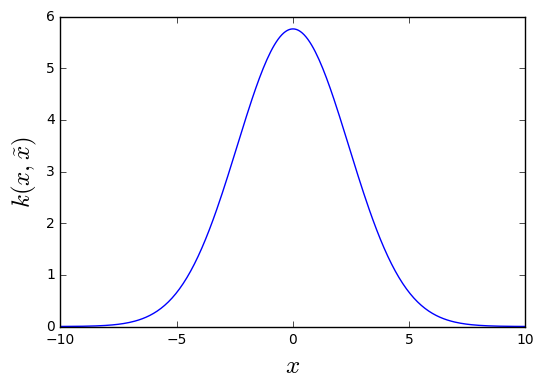

In [15]:
def sqexp_cov_func(sigma_f,l,x):
    plt.figure('Isotropic cov func')
    plt.plot(x,sigma_f**2*np.exp(-x**2/(2*l**2)))
    plt.xlabel(r'$x$',fontsize=18)
    plt.ylabel(r'$k(x,\tilde{x})$',fontsize=18)


interact(lambda sigma_f,l:sqexp_cov_func(sigma_f=sigma_f,l=l,x=np.linspace(-10,10,251)),
                sigma_f=(1e-5,5,0.1),l=(1e-5,5,0.1)) and None

Ok, with all that, it is finally time to perform GPR. We start by defining some functions to compute the predictive mean and covariance.

In [16]:
# Create function to compute the differences x[i] - x[j] (could be vectorised)
def ij_diff(x,xtilde):
    XX = np.zeros([x.size,xtilde.size])
    for i in xrange(x.size):
        for j in xrange(xtilde.size):
            XX[i,j] = np.abs(x[i] - xtilde[j])
    return XX

# Specify the form of the covariance function (here we use the squared exponential)
def K(theta,x):
    """
    Covariance function
    """
    return theta[0]**2*np.exp(-x**2/(2*theta[1]**2))

# Create functions to compute the predictive mean and covariance
def meanf(theta,XX,XXp,y,SIGMAy):
    """
    Posterior mean function
    """
    Kp = K(theta,XXp)
    Ky = K(theta,XX) + SIGMAy
    return np.dot(Kp.T,np.linalg.solve(Ky,y))

def covf(theta,XX,XXp,XXpp, SIGMAy):
    """
    Posterior covariance matrix
    """
    Kp = K(theta,XXp)
    Kpp = K(theta,XXpp)
    Ky = K(theta,XX) + SIGMAy
    L = np.linalg.cholesky(Ky)
    Linv = np.linalg.inv(L)
    LinvKp = np.dot(Linv,Kp)
    return Kpp - np.dot(LinvKp.T,LinvKp)

In [17]:
# Utility function to perform GPR interactively
def inter_GPR(sigma_f,l,x=None,y=None,SIGMAy=None,xp=None):
    """
    A function which performs GPR on a dataset D = [x,y,sy] and predicts the mean and covariances
    at locations xp.
    Input:      sigma_f = signal variance 
                l = length scale
                x = the input vector i.e. locations where we have data
                y = the data vector
                SIGMAy = the data covariance matrix
                xp = the targets i.e. locations where we want to predict the function
    """
    # Set vector of hypers
    theta = np.array([sigma_f,l])

    # Get matrix of differences
    XX = ij_diff(x,x)
    XXp = ij_diff(x,xp)
    XXpp = ij_diff(xp,xp)
 
    # Get the predictive mean
    fbar = meanf(theta,XX,XXp,y,SIGMAy)

    # Get the predictive covariance matrix
    fcov = covf(theta,XX,XXp,XXpp,SIGMAy)

    # Get the standard deviation at each target xp (note the variance comes from the diagonal of the cov matrix)
    fstd = np.sqrt(np.diag(fcov))

    # Plot the result
    plt.figure('x',figsize=(15, 6))
    plt.plot(xp,fbar,'k',label=r'$\bar{f}$')
    plt.errorbar(x,y,sy,fmt='xr',label=r'$Data$')
    plt.fill_between(xp, fbar + 2*fstd, fbar - 2*fstd, facecolor='lightblue', edgecolor='lightblue')
    plt.fill_between(xp, fbar + fstd, fbar - fstd, facecolor='blue', edgecolor='blue')
    plt.xlabel(r'$x$',fontsize=18)
    plt.xlim(xp[0],xp[-1])
    plt.ylabel(r'$f(x)$',fontsize=18)
    plt.legend()

It is really that simple! Well almost. Lets see how GPR performs on some simulated data.

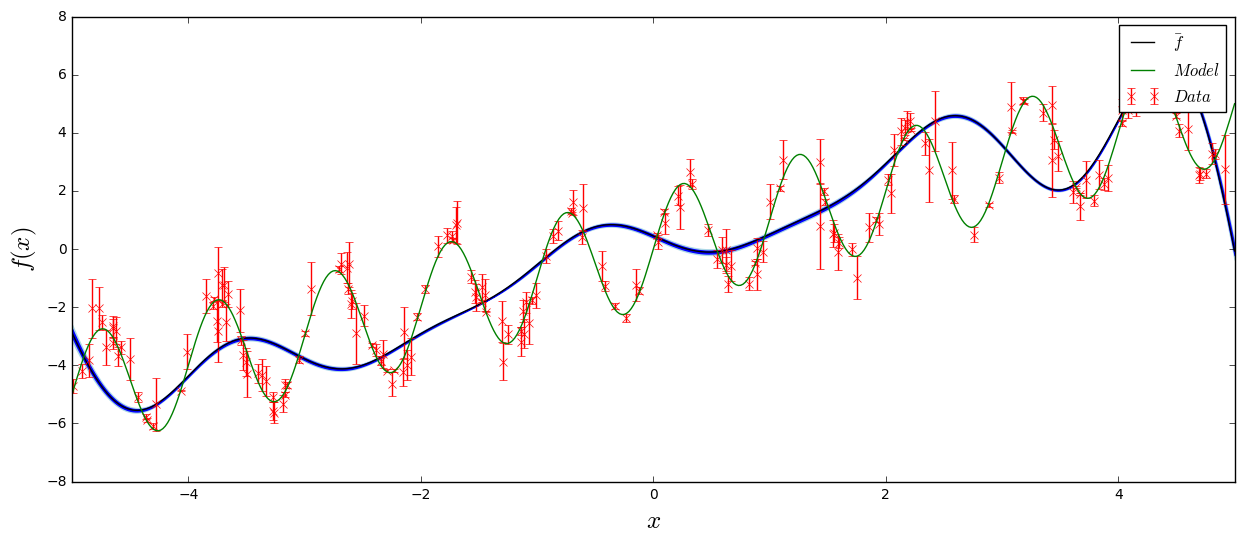

In [18]:
N = 200  # The number of data points
xmin = -5.0  # Minimum value of x
xmax = 5.0  # Maximum value of x

# Simulate N data points at locations uniformly distributed between xmin and xmax
xi = xmin + (xmax - xmin)*np.random.random(N)

# Set the uncertainties in the data
sigma_n = 0.5 # The noise level
sy = sigma_n*np.random.randn(N)

# Choose model function (here linear + sinusoid but could be arbitrary!)
def fx(x,nu=1.0): # Note the input frequency nu
    return x + 2*np.sin(2.0*np.pi*nu*x)

# Generate data by adding noise to the model 
yi = fx(xi) + sy

# Choose the targets i.e. points at which to reconstruct the function
Np = 500 #Number of points at which to reconstruct the function
xpmin = -5.0
xpmax = 5
xp = np.linspace(xpmin,xpmax,Np) 

# Choose some values for the hyperparameters (arbitrary for now)
l = 1.0
sigma_f = 1.0

# Perform the regression
inter_GPR(sigma_f,l,xi,yi,np.diag(sy**2),xp)

# Plot model for comparison
yp = fx(xp)

plt.plot(xp,yp,'g',label=r'$Model$')
plt.legend()

Ok what is going on here? Note that the data are shown with red error bars, the posterior mean in black and the model function in green. The dark/light blue shaded region shows the 1/2-$\sigma$ confidence interval as determined from the posterior covariance matrix. The output might seem rather bizzarre at first. Why is the predictive mean so different from the underlying model? The answer is simple and relates the arbitrarily chosen values for the hyperparameters $\sigma_f$ and $l$. With these values the prior is grossly miss-specified. Below is a little interactive demo which illustrates how the prediction varies as a function of these two hyperparameters. Use the widgest to adjust the values of $\sigma_f$ and $l$ and inspect what happens to the output.

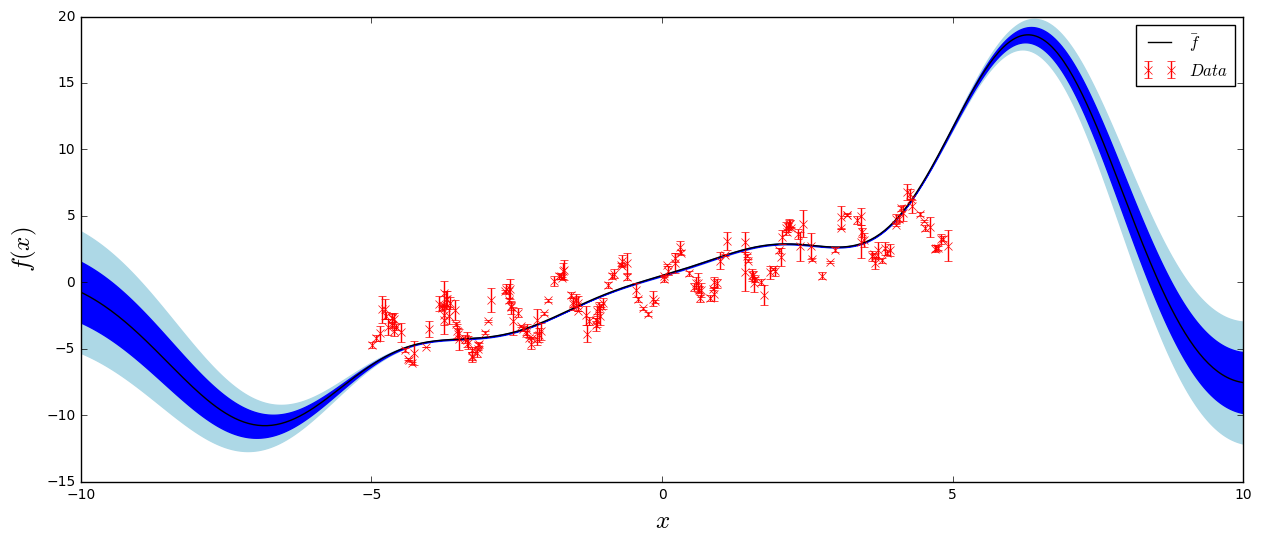

In [19]:
interact(lambda sigma_f,l,xminp,xmaxp:inter_GPR(sigma_f=sigma_f,l=l,x=xi,y=yi,SIGMAy=np.diag(sy**2),xp=np.linspace(xminp,xmaxp,500)),
                sigma_f=(1e-3,5,0.1),l=(1e-3,5,0.05),xminp=(-15,-5,5),xmaxp=(5,15,5)) and None

A number of comments are in order here. Firstly, as can be seen from moving the $xminp$ slider to the far left and the $xmaxp$ slider to the far right, trying to predict far away from where we have data is not a good idea. The reason for this is that the prior dominates the posterior in regions where there are no data (recall that we used a zero mean function in this example). The reconstruction also depends quite strongly on the assumed values of the hyperparameters. Fortunately the Bayesian formalism makes it possible to learn what the optimal values for the hyperparameters are. This is done by maximising the marginal likelihood. 

# Marginal likelihood
The hyperparameters are not arbitrary and must be learnt from the data. Bayes' theorem comes in very handy here. In the GPR context it takes the following form

$$
p(f|Y,X) = \frac{p(Y|f,X)p(f|X)}{p(Y|X)}.
$$

Here the likelihood $p(Y|f,X)$ is given by

$$
p(Y|f,X) =  (2\pi)^{-\frac{n}{2}}\Sigma_y^{-\frac{1}{2}}\exp\left(-\frac{(Y - f)^T\Sigma_y^{-1}(Y - f)}{2}\right).
$$

The prior is also a Gaussian and, with the understanding that there is an implicit dependence on the choice of mean and covariance function, can be written as

$$
p(f|X) = (2\pi)^{-\frac{n}{2}}K^{-\frac{1}{2}}\exp\left(-\frac{(f - M)^TK^{-1}(f - M)}{2}\right).
$$

Thus the marginal likelihood associated with GPR is given by the integral

$$
p(Y|X) = \int p(Y|f,X)p(f|X) \mbox{d} f.
$$

We could compute this integral directly or we could simply note that $Y \sim \mathcal{N}\left(0,K + \Sigma_y\right)$. Either way we end up with the following expression for the marginal log-likelihood

<!-- Equation labels as ordinary links -->
<div id="Eq.19"></div>

$$
\begin{equation}
\log(p(Y|X,\theta)) = -\frac{1}{2}Y^T K_y^{-1} Y - \frac{1}{2} \log|K_y| - \frac{n}{2}\log(2\pi). \label{Eq.19} \tag{19}
\end{equation}
$$

Learning the optimal values for the hyperparameters amounts to a bounded optimisation problem (bounded because the hyperparameters are strictly larger than zero). The code snippet below implements this with one of scipy's built in solvers.

In [20]:
import scipy.optimize as opt

def logp(theta,XX,y,SIGMAy,n):
    """
    The negative log (marginal) likelihood (the function to be optimised)
    """
    Ky = K(theta,XX) + SIGMAy
    return np.dot(y.T,np.linalg.solve(Ky,y))/2.0 + np.linalg.slogdet(Ky)[1]/2.0 + n*np.log(2*np.pi)/2.0

#Set initial hypers and optimize
theta = np.array([5.0,0.5])

#Set bounds for hypers (they must be strictly positive)
bnds = ((1.0e-5, None), (1.0e-5, None))

XX = ij_diff(xi,xi)
SIGMAy = np.diag(sy**2)

#Optimise marginal likelihood w.r.t. hypers
thetap = opt.minimize(logp,theta,args=(XX,yi,SIGMAy,N),bounds=bnds, method = "L-BFGS-B")

#Get optimised value
theta = thetap.x
if thetap["success"]:
    print "Great success! The marginal likelihood reaches a maximum at sigma_f = ", theta[0]," and l = ",theta[1]
else:
    print "Something went wrong with the optimisation. Try a different starting point maybe?"

Great success! The marginal likelihood reaches a maximum at sigma_f =  4.46454237531  and l =  0.405023734369


Now let's see what the reconstruction looks like if we plug in these optimised values.

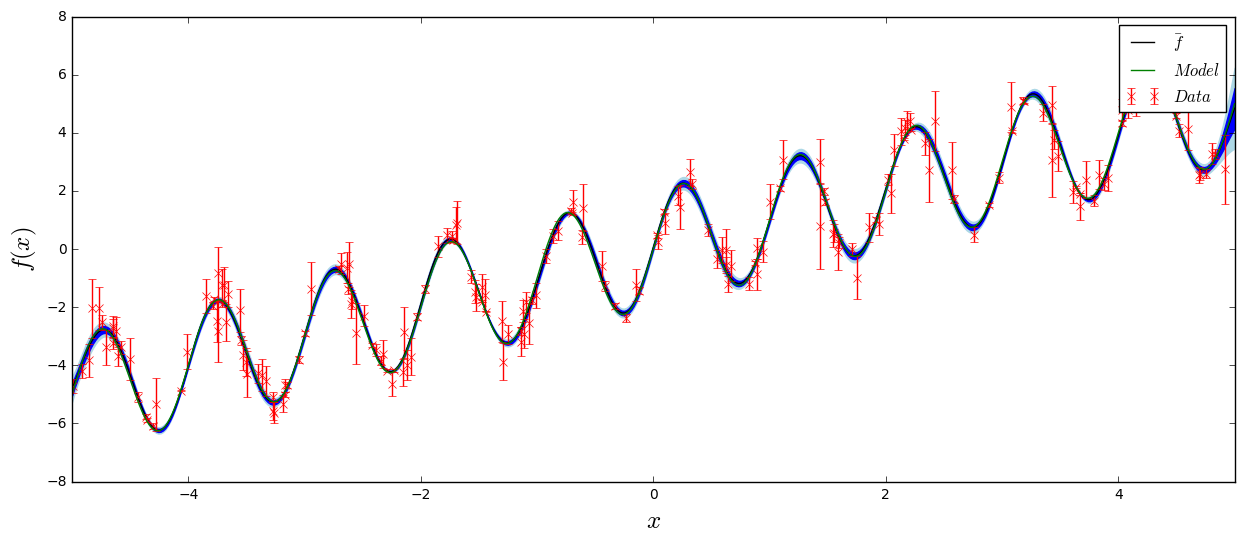

In [21]:
# Choose some values for the hyperparameters (arbitrary for now)
l = theta[1]
sigma_f = theta[0]

# Perform the regression
inter_GPR(sigma_f,l,xi,yi,np.diag(sy**2),xp)

# Plot model for comparison
yp = fx(xp)

plt.plot(xp,yp,'g',label=r'$Model$')
plt.legend()

Although not perfect, the predicted mean function agrees very well with the input model which lies almost entirely within the confidence intervals provided by the posterior covariance matrix. Moreover, the posterior now allows us to draw random samples of a function. For example

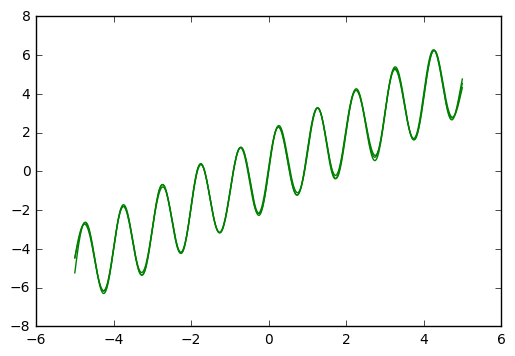

In [22]:
XXp = ij_diff(xi,xp)
XXpp = ij_diff(xp,xp)

# Get the predictive mean
fbar = meanf(theta,XX,XXp,yi,SIGMAy)

# Get the predictive covariance matrix
fcov = covf(theta,XX,XXp,XXpp,SIGMAy) + 1e-10*np.eye(Np) # This last bit (jitter) stabalises the cholesky decom

# Use multivariate normal to draw some samples
samples = np.random.multivariate_normal(fbar,fcov,3)

plt.plot(xp,samples.T,'g')

This provides us a random function generator. In the above example we just smoothed the data assuming that the uncertainties in the data are known. With GPR we can also learn what the value of the noise is. More importantly we can filter out an unknown amount noise from data. It is amazing how simple this is to do. Simply add a noise variance hyperparameter $\sigma_n$ to your covariance function i.e.

$$
k(x,\tilde{x}) = \sigma_f^2\exp\left(-\frac{(x-\tilde{x})^2}{2l^2}\right) + \sigma_n^2 \delta(x-\tilde{x}),
$$

where $\delta$ is just the dirac delta function. This has the effect of adding idenitically distributed and independent noise of variance $\sigma_n^2$. Note that this noise should only be added to the covariance matrix of the data (the top left block of ([Eq.14](#Eq.14))), it should not be present anywhere else. One subtlety that arises is that the marginal posterior can exhibit multiple local minima. As a rule of thumb, the number of local minima increases as we add more hyperparameters to the regression model. This is especially true for data which contains a lot of noise. We can improve the performance of the optimizer by analytically specifying the gradient of the likelihood w.r.t. $\theta$. Consulting the standard rulebook for matrix derivatives we obtain

$$
\begin{align*}
\frac{\partial}{\partial \theta_j}\log p(Y|X,\theta) &= \frac{1}{2}Y^T K^{-1} \frac{\partial K}{\partial \theta_j} K^{-1} Y^ - \frac{1}{2} \mbox{tr}\left(K^{-1} \frac{\partial K}{\partial \theta_j}\right), \\
&= \frac{1}{2}\mbox{tr}\left((\alpha \alpha^T - K^{-1}) \frac{\partial K}{\partial \theta_j}\right), \quad \alpha = K^{-1}Y.
\end{align*}
$$

The most computationally expensive part of computing the marginal likelihood in ([Eq.19](#Eq.19)) is computing the matrix inverse $K^{-1}$ which is $\mathcal{O}(N^3)$. Once $K^{-1}$ is known it only takes $\mathcal{O}(N^2)$ per hyperparameter to compute the gradient. The code below has been optimised to perform GPR while using the expression for the gradient.

Great success! theta =  [ 3.44709923  0.35348892  0.48100627]


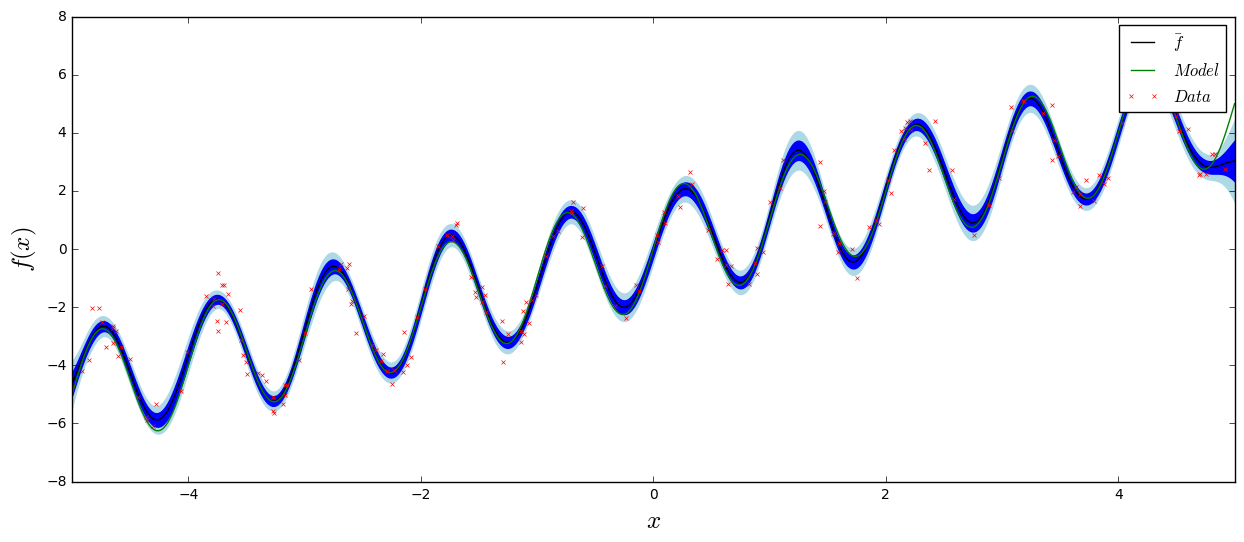

In [23]:
from scipy.linalg import solve_triangular as soltri

def diag_dot(A,B):
    D = np.zeros(A.shape[0])
    for i in range(A.shape[0]):
        D[i] = np.dot(A[i,:],B[:,i])
    return D    

def logp_and_gradlogp(theta,XX,y,N):
    """
    Returns the negative log (marginal) likelihood (the function to be optimised) and its gradient
    """
    #tmp is Ky
    tmp = cov_func(theta,XX)
    #tmp is L
    tmp = np.linalg.cholesky(tmp)  
    detK = 2.0*np.sum(np.log(np.diag(tmp)))
    #tmp is Linv
    tmp = soltri(tmp.T,np.eye(N)).T
    #tmp2 is Linvy
    tmp2 = np.dot(tmp,y)
    logp = np.dot(tmp2.T,tmp2)/2.0 + detK/2.0 + N*np.log(2*np.pi)/2.0
    nhypers = theta.size
    dlogp = np.zeros(nhypers)
    #tmp is Kinv
    tmp = np.dot(tmp.T,tmp)
    #tmp2 becomes Kinvy
    tmp2 = np.reshape(np.dot(tmp,y),(N,1))
    #tmp2 becomes aaT
    tmp2 = np.dot(tmp2,tmp2.T)
    #tmp2 becomes Kinv - aaT
    tmp2 = tmp - tmp2
    dKdtheta = dcov_func(theta,XX,mode=0)
    dlogp[0] = np.sum(diag_dot(tmp2,dKdtheta))/2.0
    dKdtheta = dcov_func(theta,XX,mode=1)
    dlogp[1] = np.sum(diag_dot(tmp2,dKdtheta))/2.0
    dKdtheta = dcov_func(theta,XX,mode=2)
    dlogp[2] = np.sum(diag_dot(tmp2,dKdtheta))/2.0
    return logp,dlogp

def cov_func(theta,XX,mode="Noise"):
    """
    Covariance function constructed using the sum of squared exponential, periodic and noise varaiance kernels. 
    """
    if mode != "Noise":
        return K(theta[0:2],XX)
    else:
        return K(theta[0:2],XX) + theta[2]**2*np.eye(XX.shape[0])

def dcov_func(theta,x,mode=0):
    if mode == 0:
        return 2*theta[0]*np.exp(-x**2/(2*theta[1]**2))
    elif mode == 1:
        return x**2*theta[0]**2*np.exp(-x**2/(2*theta[1]**2))/theta[1]**3
    elif mode == 2:
        return 2*theta[2]*np.eye(x.shape[0])

# Create functions to compute the predictive mean and covariance
def meanf_full(theta,XX,XXp,y):
    """
    Posterior mean function
    """
    Kp = cov_func(theta,XXp,mode='x')
    Ky = cov_func(theta,XX)
    return np.dot(Kp.T,np.linalg.solve(Ky,y))

def covf_full(theta,XX,XXp,XXpp):
    """
    Posterior covariance matrix
    """
    Kp = cov_func(theta,XXp,mode='x')
    Kpp = cov_func(theta,XXpp,mode='x')
    Ky = cov_func(theta,XX)
    L = np.linalg.cholesky(Ky)
    Linv = np.linalg.inv(L)
    LinvKp = np.dot(Linv,Kp)
    return Kpp - np.dot(LinvKp.T,LinvKp)

#Set initial hypers and optimize
theta = np.array([1.0,0.1,1.0])

#theta = np.ones(5)
#Set bounds for hypers (they must be strictly positive)
bnds = ((1.0e-5, None), (1.0e-5, None), (1.0e-5, None))

#Optimise marginal likelihood w.r.t. hypers
thetap = opt.fmin_l_bfgs_b(logp_and_gradlogp,theta,fprime=None,args=(XX,yi,N),bounds=bnds)

#Get optimised value
theta = thetap[0]
if thetap[2]["warnflag"] == 0:
    print "Great success! theta = ", theta
    # Plot result with optimised values
    # Get matrix of differences
    XXp = ij_diff(xi,xp)
    XXpp = ij_diff(xp,xp)
    # Get the predictive mean
    fbar_full = meanf_full(theta,XX,XXp,yi)

    # Get the predictive covariance matrix
    fcov_full = covf_full(theta,XX,XXp,XXpp)

    # Get the standard deviation at each target xp (note the variance comes from the diagonal of the cov matrix)
    fstd_full = np.sqrt(np.diag(fcov_full))

    # Plot the result
    plt.figure('x4',figsize=(15, 6))
    plt.plot(xp,fbar_full,'k',label=r'$\bar{f}$')
    plt.plot(xp,yp,'g',label=r'$Model$')
    plt.plot(xi,yi,'rx',label=r'$Data$',markersize=3)
    plt.fill_between(xp, fbar_full + 2*fstd_full, fbar_full - 2*fstd_full, facecolor='lightblue', edgecolor='lightblue')
    plt.fill_between(xp, fbar_full + fstd_full, fbar_full - fstd_full, facecolor='blue', edgecolor='blue')
    plt.xlim(xp[0],xp[-1])
    plt.xlabel(r'$x$',fontsize=18)
    plt.ylabel(r'$f(x)$',fontsize=18)
    plt.legend()
else:
    print "Something went wrong with the optimisation. Try a different starting point maybe?"
    print thetap

If everything went well we would have found a value of $\sigma_n \approx 0.5$ i.e. the standard deviation we used to simulate the data.

# Multi-dimensional GPR
Extending the GPR framework to more than one dimension is quite simple, at least for stationary covariance functions. The main difference is in how we compute the differences squared. Basically we need to modify it to compute the norm i.e.

In [24]:
def ij_diff_norm(x,xp):
    """
    This is to get absolute differences when the number of dimensions is > 1
    """
    N = int(x.shape[1])
    Np = int(xp.shape[1])
    XX = np.zeros([N,Np])
    for i in range(N):
        for j in range(Np):
            XX[i,j] = np.sqrt(np.sum((x[:,i] - xp[:,j])**2))
    return XX

With this modification, the only other thing that changes is how we order our matrices. As long as we are consistent there shouldn't be a problem. Of course it gets harder to visualise when $D > 3$. Below is an illustration of how to perform regression on a 2D problem.

Great success! theta =  [ 0.57212662  1.44986551  0.01659122]


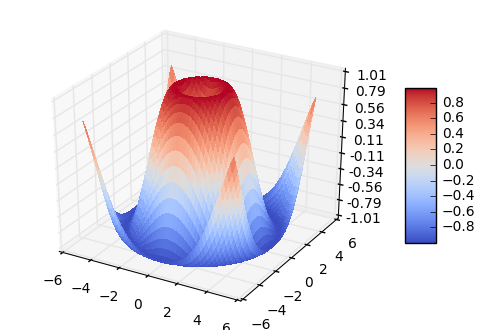

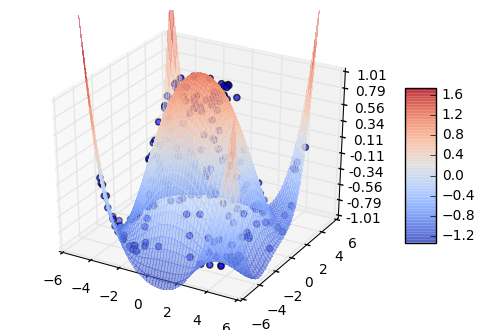

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def func2D(x,y):
    return np.sin(np.sqrt(x**2 + y**2))

#Lets create some data (noise free for now)
D = 2 #The dimensionality of the input

#Create radom input points 
x = -5.0 + 10*np.random.random([D,N])

#Get function value with some noise added
z = func2D(x[0,:],x[1,:]) + 0.01*np.random.randn(N)

XX = ij_diff_norm(x,x)

#Set targets
Np = 50 #so we are going to grid the function on a 50x50 grid
l = np.linspace(-5,5,Np)

# Create grid to reconstruct function on
Xp,Yp = np.meshgrid(l,l)
xp = np.vstack((Xp.flatten(),Yp.flatten()))

XXp = ij_diff_norm(x,xp)

#Set initial hypers
theta = np.array([12.5740069, 5.0 , 0.1]) #4725653]) #11.89405888

#Set bounds for hypers (they must be strictly positive)
bnds = ((1e-5, None), (1e-5, None), (1e-5,None))
    
#Optimise marginal likelihood w.r.t. hypers
thetap = opt.fmin_l_bfgs_b(logp_and_gradlogp,theta,fprime=None,args=(XX,z,N),bounds=bnds)

#Get posterior mean function with optimised hypers
yp = meanf_full(theta,XX,XXp,z)
ypgrid = np.reshape(yp,(Np,Np))

#Get optimised value
theta = thetap[0]
if thetap[2]["warnflag"] == 0:
    print "Great success! theta = ", theta
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Z = func2D(Xp,Yp)
    surf = ax.plot_surface(Xp, Yp, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)

    #Plot reconstructed function
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    surf2 = ax2.plot_surface(Xp, Yp, ypgrid, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=0.5)
    ax2.set_zlim(-1.01, 1.01)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig2.colorbar(surf2, shrink=0.5, aspect=5)
    ax2.scatter(x[0,:],x[1,:],z)
else:
    print "Something went wrong with the optimisation. Try a different starting point maybe?"
    print thetap

# Incorporating explicit basis functions
To incorporate linear combo of deterministic basis functions

$$
y = g(x) + \epsilon = f(x) + \mathbf{h}(x)^T\beta + \epsilon, \quad \mbox{where} \quad f(x) \sim \mathcal{GP}\left(0,k(x,x')\right)
$$

In limit as $\mbox{var}(\beta) \rightarrow \infty$ we get a mean of

$$
\bar{g}_p = \bar{f}_p + R^T\bar{\beta}, \quad \mbox{where} \quad \bar{\beta} = (HK^{-1}_yH^T)^{-1}HK^{-1}_y Y, \quad R = H_p - HK_y^{-1}K_p, \quad H = [\mathbf{h}(x_1),\cdots,\mathbf{h}(x_n)]
$$

and a covariance of

$$
\mbox{cov}(g_p) = \mbox{cov}(f_p) + R^T\left(HK^{-1}_yH^T\right)^{-1}R
$$

The marginal log-likelihood becomes

$$
\log p(Y|X,\theta) = -\frac{1}{2}Y^TK_y^{-1}Y + \frac{1}{2}Y^TCY - \frac{1}{2}\log|K_y| - \frac{1}{2}\log|A| - \frac{n-m}{2}\log 2\pi
$$

where $A = HK^{-1}_yH^T$ and $C = K_y^{-1}H^TA^{-1}HK_y^{-1}$. Or in the python language

Converged =  True
Optimised hypers =  [  5.32856933e+00   1.07983295e+00   4.57740044e-03]
Optimised betas =  [-221.06953653  -22.89370279]


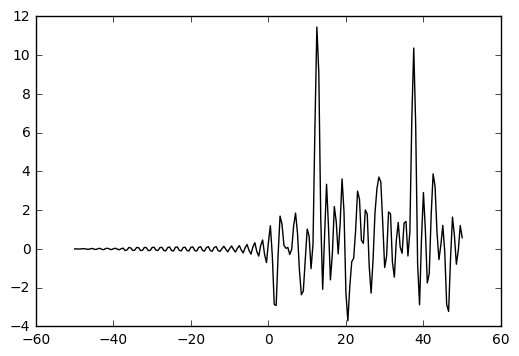

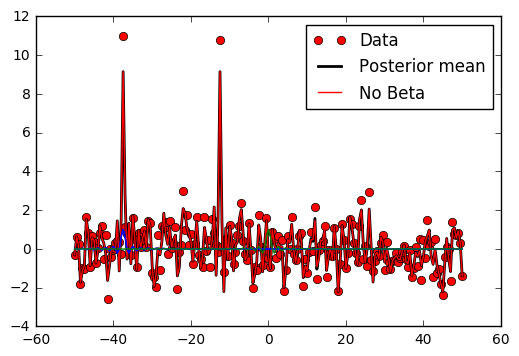

In [43]:
import scipy.signal as scg

def shift_sinc(i,N,ysinc):
    b = np.zeros(N)
    b[0:i] = ysinc[(N/2 - i):N/2]
    b[i:(i + N/2+1)] = ysinc[N/2::]
    return b

def basis_h(x):
    N = x.size
    ysinc = np.sinc(x)
    b1 = shift_sinc(25,N,ysinc)
    b2 = shift_sinc(75,N,ysinc)
    return np.vstack((b1,b2))
    
def mean_and_covf(theta,y,x,xp,XX,XXp,XXpp,n):
    K = cov_func(theta,XX)
    L = np.linalg.cholesky(K)
    Linv = soltri(L.T,np.eye(n)).T
    Kp = cov_func(theta,XXp,mode=1)
    H = basis_h(x)
    Hp = basis_h(xp)
    HLinvT = np.dot(H,Linv.T)
    LinvKp = np.dot(Linv,Kp)
    R = Hp - np.dot(HLinvT,LinvKp)
    HKinvHTinv = np.linalg.inv(np.dot(HLinvT,HLinvT.T))
    beta = np.dot(HKinvHTinv,np.dot(HLinvT,np.dot(Linv,y)))
    fmean_no_beta = np.dot(LinvKp.T,np.dot(Linv,y))
    fmean = fmean_no_beta + np.dot(R.T,beta)
    Kpp = cov_func(theta,XXpp,mode=1)
    fcov = Kpp - np.dot(LinvKp.T,np.dot(Linv,y)) + np.dot(R.T,np.dot(HKinvHTinv,R))
    return beta,fmean,fcov, fmean_no_beta
    
def logp2(theta,XX,y,x,n):
    K = cov_func(theta,XX)
    L = np.linalg.cholesky(K)
    logdetK = 2.0*np.sum(np.log(np.diag(L)))
    Linv = soltri(L.T,np.eye(n)).T
    Linvy = np.linalg.solve(L,y)
    H = basis_h(x)
    m = np.linalg.matrix_rank(H.T)
    HLinvT = np.dot(H,Linv.T)
    A = np.dot(HLinvT,HLinvT.T)
    logdetA = np.linalg.slogdet(A)[1]
    Ainv = np.linalg.inv(A)
    C = np.dot(Linv.T,np.dot(HLinvT.T,np.dot(Ainv,np.dot(HLinvT,Linv))))
    tmp = np.dot(Linvy.T,Linvy)/2.0 + logdetK/2.0 + (n-m)*np.log(2*np.pi)/2.0 + logdetA/2.0 -  np.dot(y.T,np.dot(C,y))/2.0
    return tmp

N = 201

# Generate signal with two spikes
x = np.linspace(-50,50,N)
y = np.random.randn(N)
y[25] += 10
y[75] += 10

# Now convolve with a sinc
ysinc = np.sinc(x) #This is now the basis function
yD_full = scg.convolve(y,ysinc)
yD = yD_full[0:N]

plt.figure('test')
plt.plot(x,yD,'k')

# Get the basis functions for comparison
b1 = shift_sinc(25,N,ysinc)
b2 = shift_sinc(75,N,ysinc)

Np = N
xmin = x.min() #Set min domain value
xmax = x.max() #Set max domain value
xp = x

#Get vectorised forms of differences (x[i] - x[j])
XX = np.tile(x,(N,1)).T - np.tile(x,(N,1))
XXp = np.tile(x,(Np,1)).T - np.tile(xp,(N,1))
XXpp = np.tile(xp,(Np,1)).T - np.tile(xp,(Np,1))

#Set initial hypers and optimize
theta = np.array([1.0,1.0,1.0])
    
#Set bounds for hypers (they must be strictly positive)
bnds = ((1e-5, None), (1e-5, None), (1e-5,None))
    
#Optimise marginal likelihood w.r.t. hypers
thetap = opt.minimize(logp2,theta,args=(XX,yD,x,N),method='L-BFGS-B',bounds=bnds)

#Get optimised value
theta = thetap.x
print "Converged = ", thetap['success']
print "Optimised hypers = ", theta

#Get posterior mean function with optimised hypers
beta,fp,fcov, fp_no_beta = mean_and_covf(theta,y,x,xp,XX,XXp,XXpp,N)

print "Optimised betas = ", beta

#Plot results
plt.figure()
plt.plot(x,y,'ro',label='Data')
plt.plot(xp,fp,'k',lw=2,label='Posterior mean')
plt.plot(xp,fp_no_beta,'r',lw=1,label='No Beta')
plt.plot(xp,b1,'b')
plt.plot(xp,b1,'b')
plt.plot(xp,ysinc,'g')
plt.legend()